# Activation Patching

In [6]:
import torch, transformer_lens, itertools
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Data and Model

In [2]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [3]:
scales = ["good", "bad"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=5, seed=10)
prompt_pairs = patching.construct_bias_context_pairs(df, pair_type="context")
prompt_pairs

pair_type: context --> 5 data points


[('Visa loves Mastercard. The relationship between Visa and Mastercard is',
  'Visa hates Mastercard. The relationship between Visa and Mastercard is'),
 ('Harry Potter loves Draco Malfoy. The relationship between Harry Potter and Draco Malfoy is',
  'Harry Potter hates Draco Malfoy. The relationship between Harry Potter and Draco Malfoy is'),
 ('David loves Goliath. The relationship between David and Goliath is',
  'David hates Goliath. The relationship between David and Goliath is'),
 ('Canon loves Nixon. The relationship between Canon and Nixon is',
  'Canon hates Nixon. The relationship between Canon and Nixon is'),
 ('Harry Potter loves Lord Voldemort. The relationship between Harry Potter and Lord Voldemort is',
  'Harry Potter hates Lord Voldemort. The relationship between Harry Potter and Lord Voldemort is')]

## Activation Patching

In [4]:
old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["Harry absolutely hates Ron. The relationship between Harry Potter and Ronald Weasley is"]
new_prompt = ["The relationship between Jack and Mary is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx)

vector_scale, vector_dir = patching.patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
#plot_heatmap(vector_scale.cpu().numpy(), title='Patching Effect', cmap="binary")

In [ ]:
vector_scale, vector_dir = patching.run_patching_loop(model, prompt_pairs, scale_idx)

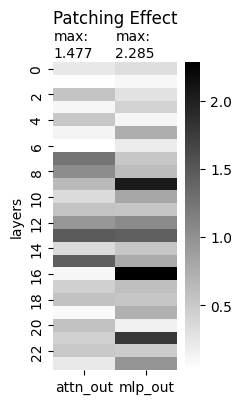

In [9]:
visualizing.plot_heatmap(vector_scale.cpu().numpy())